In [243]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm

## Birth Weight Paradox

In [209]:
prior_smoking = 0.48
prior_birth_defect = 0.05
# prior_birth_weight will be normal distribution around 0.8 to 1.2
prior_mortality = 0.01

# Causal Model:
# Mortality <- Birth Weight <- Smoking -> Mortality <- Birth Defect -> Birth Weight

effect_birth_weight_on_mortality = -0.3
effect_smoking_on_birth_weight = -0.25
effect_smoking_on_mortality = 4
effect_birth_defect_on_mortality = 12
effect_birth_defect_on_birth_weight = -0.25

random.seed(42)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [birth_defect]
>>Metropolis: [smoking]
>NUTS: [birth_mortality_base, birth_weight_base]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:13<00:00, 366.57draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


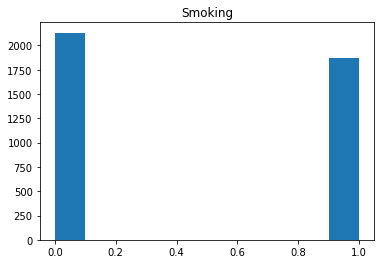

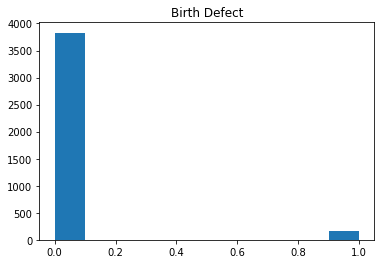

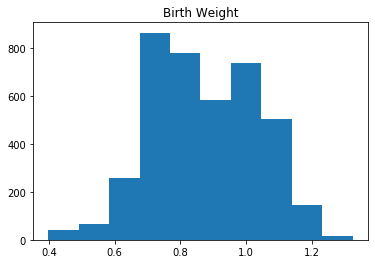

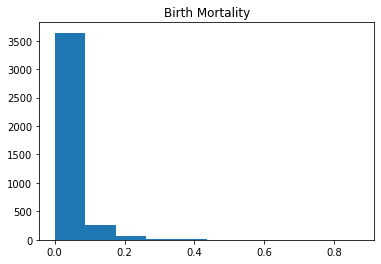

In [227]:
import math

with pm.Model() as smoking_birth_weight:
    smoking = pm.Binomial("smoking", 1, prior_smoking)
    birth_defect = pm.Binomial("birth_defect", 1, prior_birth_defect)
    birth_weight_before_effects = pm.Normal("birth_weight_base", mu=1.0, sigma=0.1)
    birth_weight = pm.Deterministic("birth_weight",
                                    birth_weight_before_effects +
                                    birth_weight_before_effects * smoking * effect_smoking_on_birth_weight +
                                    birth_weight_before_effects * birth_defect * effect_birth_defect_on_birth_weight 
                                   )
  
    # Since we are using an exponential a small number will cause big output values, while a big number will
    # cause small output values, since we are looking for something between 0 and 1, we want the inverse
    # of 0.01 which is a 100
    logaritmic_prior_mortality = 10 ** (math.log(prior_mortality, 10) * -1)
    birth_mortality_before_effects = pm.Exponential("birth_mortality_base", logaritmic_prior_mortality)
    birth_mortality = pm.Deterministic("birth_mortality",
                                    birth_mortality_before_effects +
                                    birth_mortality_before_effects * smoking * effect_smoking_on_mortality +
                                    birth_mortality_before_effects * birth_defect * effect_birth_defect_on_mortality +
                                    birth_mortality_before_effects * birth_weight * effect_birth_weight_on_mortality 
                                   )
    
    trace = pm.sample(2000)

plt.hist(trace["smoking"])
plt.title("Smoking")
plt.show()

plt.hist(trace["birth_defect"])
plt.title("Birth Defect")
plt.show()

plt.hist(trace["birth_weight"])
plt.title("Birth Weight")
plt.show()

plt.hist(trace["birth_mortality"])
plt.title("Birth Mortality")
plt.show()

In [229]:
from IPython.display import display

data = np.array([trace["smoking"], trace["birth_defect"], trace["birth_weight"], trace["birth_mortality"]]).T
df = pd.DataFrame(data, columns=['smoking', 'birth_defect', 'birth_weight', 'mortality'])
display(df.head())

corr = df.corr()
corr.style.background_gradient()

,smoking,birth_defect,birth_weight,mortality
0,1.0,0.0,0.736133,0.007589
1,1.0,0.0,0.745401,0.230171
2,1.0,0.0,0.683245,0.022955
3,0.0,0.0,1.090145,0.004093
4,0.0,0.0,0.975409,0.012335


,smoking,birth_defect,birth_weight,mortality
smoking,1,0.00520228,-0.775282,0.324347
birth_defect,0.00520228,1,-0.312391,0.470657
birth_weight,-0.775282,-0.312391,1,-0.400047
mortality,0.324347,0.470657,-0.400047,1


In [230]:
print("mortality underweight smoking mother:", "%.2f" % df[(df['birth_weight'] < 0.7) & (df['smoking'] == 1)].mortality.mean())
print("mortality underweight non-smoking mother:", "%.2f" % df[(df['birth_weight'] < 0.7) & (df['smoking'] == 0)].mortality.mean())

mortality underweight smoking mother: 0.06
mortality underweight non-smoking mother: 0.15


Apparently mothers with underweight babies have a smaller mortality rate if they smoke, that's the birth weight paradox.

It's caused by the collider bias, birth weight is the collider. By conditioning on birth weight we add a spurious negative correlation between smoking and mortality, which bias the real effect of smoking on mortality

The thing is, if the baby is underweight because the mother smokes, it is less bad then when the baby is underweight because of a birth defect.

Looking from another perspective: if the baby is underweight and we find that the mother is a smoker, that explains away the low weight, reducing the probability it was caused by a more serious birth defect. OTOH if the mother doesn't smoke, then probably the baby is underweight for a more life-threatening issue.

So let's not condition on birth weight:

In [231]:
print("mortality smoking mother:", "%.2f" % df[df['smoking'] == 1].mortality.mean())
print("mortality non-smoking mother:", "%.2f" % df[df['smoking'] == 0].mortality.mean())

mortality smoking mother: 0.05
mortality non-smoking mother: 0.01


You can see that smoking mothers have a way bigger mortality rate that those who doesn't.

Now, if you do want to condition on birth weight, you have to control for birth defect:

In [232]:
print("mortality underweight smoking mother no-defect:", "%.2f" % df[(df['birth_weight'] < 0.7) & (df['smoking'] == 1) & (df['birth_defect'] == 0)].mortality.mean())
print("mortality underweight non-smoking mother no-defect:", "%.2f" % df[(df['birth_weight'] < 0.7) & (df['smoking'] == 0) & (df['birth_defect'] == 0)].mortality.mean())
print("")
print("mortality underweight smoking mother defect:", "%.2f" % df[(df['birth_weight'] < 0.7) & (df['smoking'] == 1) & (df['birth_defect'] == 1)].mortality.mean())
print("mortality underweight non-smoking mother defect:", "%.2f" % df[(df['birth_weight'] < 0.7) & (df['smoking'] == 0) & (df['birth_defect'] == 1)].mortality.mean())

mortality underweight smoking mother no-defect: 0.05
mortality underweight non-smoking mother no-defect: 0.01

mortality underweight smoking mother defect: 0.15
mortality underweight non-smoking mother defect: 0.21


## Simpson's Paradox

In [1074]:
effect_exercise_on_cholesterol = -1
effect_age_on_cholesterol = 3
effect_age_on_exercises = 1

# Model:
# age -> cholesterol <- exercises <- age

ages = np.array(range(100, 500)) / 10
exercises = [ z / 5 * (effect_age_on_exercises + noise()) for z in ages ]
cholesterol = [ z // 10 * (effect_age_on_cholesterol + noise()) +
                x * (effect_exercise_on_cholesterol + noise()) for x, z in zip(exercises, ages) ]

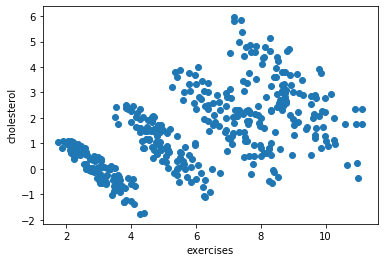

In [1075]:
from matplotlib.patches import Ellipse

# Uncomment to see more or less the age groups
# for age_group in range(10, 50, 10):
#     exercises_for_age = exercises[age_group-10:age_group]
#     cholesterol_for_age = cholesterol[age_group-10:age_group]
#     circle = Ellipse((age_group / 6 + 1.5, age_group / 7 - 1.8), 2, 4 + age_group * 0.07, angle=35, color='r', fill=False, clip_on=False)
#     plt.gca().add_artist(circle)

plt.scatter(x = exercises, y = cholesterol)
plt.xlabel("exercises")
plt.ylabel("cholesterol")

plt.show()

Looking at the graph above it looks like the more you exercise, the higher your cholesterol is, so it exercising actually bad for your health? 

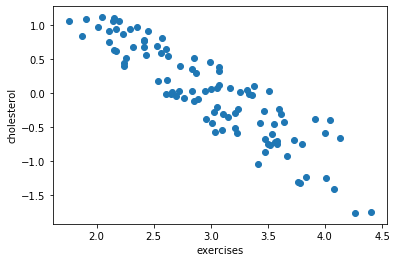

In [1076]:
plt.scatter(x = exercises[0:100], y = cholesterol[0:100])
plt.xlabel("exercises")
plt.ylabel("cholesterol")
plt.show()

No, actually there is a confounder: age. If we take a slice of the data focused on some age group we can see that actually the more you exercise the smaller is your cholesterol. The thing is that with more age both your cholesterol increases and you tend to exercise more.

This is the Simpson's Paradox: grouped data shows a different trend from slices of the data.

### Back-Door Adjustment

As mentioned, if you just take the linear coefficient between exercises and cholesterol you'll find a positive correlation

In [1077]:
from sklearn.linear_model import LinearRegression

def linear_coef(x, y):
    x = np.array(x)
    A = np.array([ x, np.ones(len(x)) ])
    y = np.array(y)
    return np.linalg.lstsq(A.T, y, rcond=None)[0][0]

linear_coef(cholesterol, exercises)

0.8076156750539667

Instead, we can control for age by taking an average of coefficients in each age group

In [1078]:
coefs = []
for age_group in range(10, 50, 10):
    coef = linear_coef(exercises[(age_group - 10):age_group], cholesterol[(age_group - 10):age_group]) # np.corrcoef(exercises[0:age_group], cholesterol[0:age_group])[0][1]
    coefs.append(coef)
np.mean(coefs)

-1.2592573000833274

Using Formula

$ P(Y | do(X)) = \sum_{z} P(Y | X, Z = z) P(Z = z) $

In [1079]:
coefs2 = 0
for age_group in range(10, 50, 10):
    coefs2 += linear_coef(exercises[(age_group - 10):age_group], cholesterol[(age_group - 10):age_group]) * 0.25 # P(Z = z) = 0.25
coefs2 

-1.2592573000833274

Now you can see there is a negative correlation, as expected.

An even better approach is to use a multi linear regression and just take the calculated coefficient for exercise, because it will already be adjusted for age. Doing like this is also good because in many cases we don't know exactly how to split the groups

-1.0545468665822066


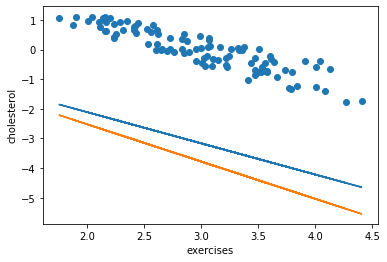

In [1080]:
from sklearn.linear_model import LinearRegression

X = np.array([exercises, ages]).T
y = cholesterol

regressor = LinearRegression()
regressor.fit(X, y)

print(regressor.coef_[0])

plt.scatter(x = exercises[0:100], y = cholesterol[0:100])

#ys = [ x * regressor.coef_[0] + z * regressor.coef_[1] + regressor.intercept_ for x, z in zip(exercises[0:100], ages[0:100]) ]
#plt.plot([ x for x in exercises[0:100]], ys)

ys = [ x * regressor.coef_[0] for x, z in zip(exercises[0:100], ages[0:100]) ]
plt.plot([ x for x in exercises[0:100]], ys)

ys = [ x * coefs2 for x, z in zip(exercises[0:100], ages[0:100]) ]
plt.plot([ x for x in exercises[0:100]], ys)

plt.xlabel("exercises")
plt.ylabel("cholesterol")
plt.show()

The slope result is close to the age groups average one

### Front-Door Criterion

Do people showing up for a job specialization course increase their earnings?

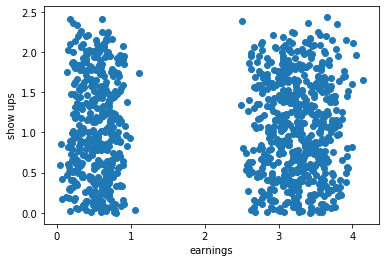

In [633]:
# Model:
# sign up -> show up <- earnings <- motivation -> sign up

effect_motivation_on_sign_up = 1.2
effect_motivation_on_earnings = 1.5
effect_sign_up_on_show_up = 1.8
effect_show_up_on_earnings = 1.1

def to_binary(xs):
    return [ 1 if x >= 0.5 else 0 for x in xs ]

motivations = [ random.random() for _ in range(0, 1000) ] 
sign_ups = to_binary([ x * (effect_motivation_on_sign_up + noise()) for x in motivations ])
show_ups = [ (x + 0.1) * (effect_sign_up_on_show_up + noise()) + noise() for x in sign_ups ]
earnings = [ y * (effect_motivation_on_earnings + noise()) +
             x * (effect_show_up_on_earnings + noise()) for x, y in zip(show_ups, motivations) ]

plt.scatter(x = earnings, y = show_ups_cont)
plt.xlabel("earnings")
plt.ylabel("show ups")

plt.show()

We can easily calculate the effect of sign_ups in show_ups because there is no confounder there

In [634]:
linear_coef(sign_ups_cont, show_ups_cont) # P(Z | X)

1.8030336791532013

But if we tried to calculate the effect of sign_ups on earnings we would have a much bigger effect then in reality, because motivation plays a big role in both sign_ups and earnings

In [635]:
linear_coef(sign_ups, earnings)

2.7331978220543705

Instead, to calculate the real effect of sign ups and remove the earnings bias, we use the front-door criterion:

Using the Formula

$ P(Y | do(X)) = \sum_{z} P(Z = z, X) \sum_{x} P(Y | X = x, Z = z) P(X = x) $

$ X = sign\ ups $

$ Y = earnings $

$ Z = show\ ups $

In [1101]:
outer_sum = 0
for z in set(show_ups):
#     x_true = [ x for x in sign_ups if x == 1 ]
#     z_equals = [ z_ for z_, x_ in zip(show_ups, sign_ups) if z_ == z ]
#     p_z_x = len(z_equals) / len(x_true)
    p_z = len([z_ for z_ in show_ups if z_ == z]) / len(show_ups)
    p_x = len([x_ for z_, x_ in zip(show_ups, sign_ups) if z_ == z and x_ == 1]) / len([z_ for z_ in show_ups if z_ == z])
    p_z_x = p_z * p_x
    

    inner_sum = 0
    for x in set(sign_ups):
        y_given_x_z = [ y for x_, y, z_ in zip(sign_ups, earnings, show_ups) if x_ == x and z_ == z ]
        x_given_x_z = [ x for x_, y, z_ in zip(sign_ups, earnings, show_ups) if x_ == x and z_ == z ]
        p_y_given_x_z = linear_coef(x_given_x_z, y_given_x_z)
    
        x_equals = [ x_ for x_ in sign_ups if x_ == x ]
        p_x = len(x_equals) / len(sign_ups)
        
        inner_sum += p_y_given_x_z * p_x
    outer_sum += p_z_x * inner_sum
outer_sum

0.4524756955992626

Let's confirm that our calculations are correct, if they are, the effect of forcing people to sign up on earnings should be 0.34. To test test, we will generate 100 new examples using the same data generation process, and calculate everything comparing the intervention scenario with the natural scenario:

In [1092]:
new_motivations = np.array(range(1, 1001)) 

natural_sign_ups = to_binary([ x * (effect_motivation_on_sign_up + noise()) for x in new_motivations ])
natural_show_ups = [ (x + 0.1) * (effect_sign_up_on_show_up + noise()) for x in natural_sign_ups ]
natural_earnings = [ y * (effect_motivation_on_earnings + noise()) +
                     x * (effect_show_up_on_earnings + noise()) for x, y in zip(natural_show_ups, new_motivations) ]

intervention_sign_ups = [ 1 for x in new_motivations ]
intervention_show_ups = [ (x + 0.1) * (effect_sign_up_on_show_up + noise()) for x in intervention_sign_ups ]
intervention_earnings = [ y * (effect_motivation_on_earnings + noise()) +
                          x * (effect_show_up_on_earnings + noise()) for x, y in zip(intervention_show_ups, new_motivations) ]

np.mean(intervention_earnings) / np.mean(natural_earnings)

0.9978941340316523

Amazing! The results are very close!

# Mediator

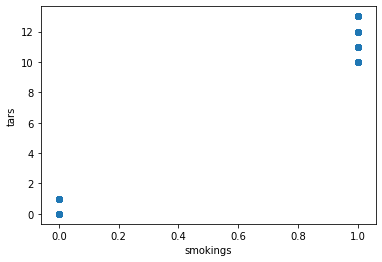

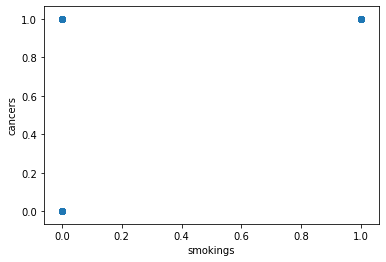

In [654]:
# Model:
# smoking -> tar -> cancer <- smoking

def noise():
    return (random.random() - 0.5) * 0.3

effect_smoking_on_tar = 1.1
effect_tar_on_cancer = 1.4
effect_smoking_on_cancer = 1.2

smokings = to_binary([ random.random() for _ in range(0, 1000) ])
tars = [ int(10 * (x + 0.1) * (effect_smoking_on_tar + noise())) for x in smokings ]
cancers = to_binary([ (x + 0.1) * (effect_smoking_on_cancer + noise()) +
            m * (effect_tar_on_cancer + noise()) for x, m in zip(smokings, tars) ])

# smokings = to_binary(smokings)
# tars = [ int(m * 10) for m in tars ]
# cancers = to_binary(cancers)

plt.scatter(x = smokings, y = tars)
plt.xlabel("smokings")
plt.ylabel("tars")
plt.show()

plt.scatter(x = smokings, y = cancers)
plt.xlabel("smokings")
plt.ylabel("cancers")
plt.show()

In [655]:
# Formula: NIE = \sum_{m} [P(M = m | X = 1) - P(M = m | X = 0)] * P(Y = 1 | X = 0, M = m)
# X = smoking, M = tar, Y = cancer

nie = 0
for m in set(tars):
    x_true = [ x for x in smokings if x == 1 ]
    x_true_for_m = [ x for x, m_ in zip(smokings, tars) if x == 1 and m_ == m ]
    p_m_given_x_true = len(x_true_for_m) / len(x_true)
    
    x_false = [ x for x in smokings if x == 0 ]
    x_false_for_m = [ x for x, m_ in zip(smokings, tars) if x == 0 and m_ == m ]
    p_m_given_x_false = len(x_false_for_m) / len(x_false)
    
    p_x_false_m_m = [ x for x, m_ in zip(smokings, tars) if x == 0 and m_ == m ]
    p_y_true_for_x_false_m_m = [ y for x, m_, y in zip(smokings, tars, cancers) if x == 0 and m_ == m and y == 1 ]
    p_y_true_given_x_false_m_m = len(p_y_true_for_x_false_m_m) / (len(p_x_false_m_m) + 0.0001)
    
    # E(Y | X = 0, M = m)
#     p_y_true_given_x_false_m_m = np.mean(p_y_true_for_x_false_m_m) if len(p_y_true_for_x_false_m_m) else 1
    
    nie += float(p_m_given_x_true - p_m_given_x_false) * float(p_y_true_given_x_false_m_m)
nie

-0.8211536538461989

In [245]:
new_smokings = [ random.random() for _ in range(0, 1000) ]

natural_tars = [ x * (effect_smoking_on_tar + noise()) for x in new_smokings ]
natural_cancers = [ x * (effect_smoking_on_cancer + noise()) +
                    m * (effect_tar_on_cancer + noise()) for x, m in zip(new_smokings, natural_tars) ]
natural_cancers = to_binary(natural_cancers)

intervention_tars = [ x * (effect_smoking_on_tar + noise()) for x in new_smokings ]
intervention_cancers = [ 0 * (effect_smoking_on_cancer + noise()) +
                        m * (effect_tar_on_cancer + noise()) for x, m in zip(new_smokings, intervention_tars) ]
intervention_cancers = to_binary(intervention_cancers)

new_smokings = to_binary(new_smokings)

natural_cancers_given_smokings = [ y for x, y in zip(new_smokings, natural_cancers) if x == 1 ]
intervention_cancers_given_smokings = [ y for x, y in zip(new_smokings, intervention_cancers) if x == 1 ]
print(np.mean(natural_cancers_given_smokings))
print(np.mean(intervention_cancers_given_smokings))
np.mean(intervention_cancers_given_smokings) / np.mean(natural_cancers_given_smokings)
# print(np.mean(cancers))
# print(np.mean(natural_cancers))

0.436399217221135
0.06457925636007827


0.14798206278026907

# Gene Strength

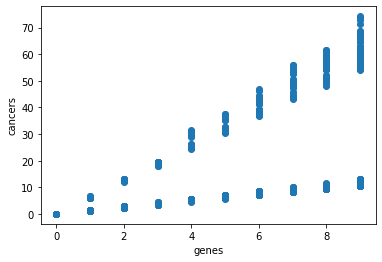

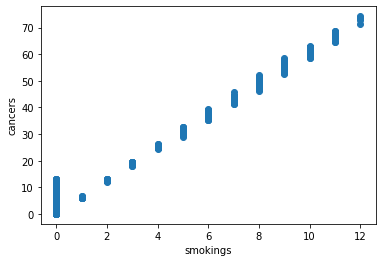

In [870]:
# Model:
# gene -> smoking -> cancer <- gene 

def noise():
    return (random.random() - 0.5) * 0.3

effect_gene_on_smoking = 1.2
effect_smoking_on_cancer = 5
effect_gene_on_cancer = 1.3

genes = [ int(random.random() * 10) for _ in range(0, 1000) ]
smokings = [ 0 if random.random() > 0.5 else int(x * (effect_gene_on_smoking + noise())) for x in genes ]
cancers = [ #0.1 if random.random() > 0.1 else
            x * (effect_smoking_on_cancer + noise()) +
            g * (effect_gene_on_cancer + noise()) for x, g in zip(smokings, genes) ]

plt.scatter(x = genes, y = cancers)
plt.xlabel("genes")
plt.ylabel("cancers")
plt.show()

plt.scatter(x = smokings, y = cancers)
plt.xlabel("smokings")
plt.ylabel("cancers")
plt.show()

In [871]:
# Using Formula
# P(Y | do(X)) = \sum_{z} P(Y | X, Z = z) P(Z = z)
coefs2 = 0
for gene in set(genes):
    P_Z = len([ z for z in genes if z == gene ]) / len(genes)
    X_given_z = [ x for x, z in zip(smokings, genes) if z == gene ]
    Y_given_z = [ y for y, z in zip(cancers, genes) if z == gene ]
    
    coefs2 += linear_coef(X_given_z, Y_given_z) * P_Z
coefs2 

4.553465873850191

In [872]:
intervention_0_smokings = [ 0 for g in genes ]
intervention_0_cancers = [ x * (effect_smoking_on_cancer + noise()) +
                           g * (effect_gene_on_cancer + noise()) for x, g in zip(intervention_0_smokings, genes) ]

intervention_1_smokings = [ 1 for g in genes ]
intervention_1_cancers = [ x * (effect_smoking_on_cancer + noise()) +
                           g * (effect_gene_on_cancer + noise()) for x, g in zip(intervention_1_smokings, genes) ]

np.mean(intervention_1_cancers) - np.mean(intervention_0_cancers)

4.990322753664906

We saw that if we can measure the gene then we see the effect of smoking on cancer. But let's consider the hypothesis that smoking doesn't cause cancer, rather that the confounding gene caused both for you to smoke and to have cancer. How strong would that need to be?

In [908]:
smokers_with_cancer = len([ 1 for x, y in zip(smokings, cancers) if x > 0 and y > 10 ])
all_smokers = len([ 1 for x in smokings if x > 0 ])
non_smokers_with_cancer = len([ 1 for x, y in zip(smokings, cancers) if x == 0 and y > 10 ])
all_non_smokers = len([ 1 for x in smokings if x == 0 ])

chance_cancer_smokers = smokers_with_cancer / all_smokers
chance_cancer_non_smokers = non_smokers_with_cancer / all_non_smokers
increased_chance = chance_cancer_smokers / chance_cancer_non_smokers

print("Smokers have", "%.1f" % increased_chance, "times more risk of having cancer")
print("This means that if", "%.1f%%" % (100 / increased_chance), "of non-smoking people had the gene, then 100% of smoking people would have to have it")

Smokers have 5.2 times more risk of having cancer
This means that if 19.3% of non-smoking people had the gene, then 100% of smoking people would have to have it
